# Failure of Conventional Numerical Methods for Stiff Equations

## Jupyter Notebook by Hridey Narula

## Introduction
>A problem worthy of attack, proves its worth by fighting back.

In Physics and Chemistry, one almost always encounters differential equations that describe the dynamics of the system. More often than not, these differential equations can not be (atleast completely) solved analytically. In such cases, it is of extreme importance to construct robust numerical algorithms capable of solving the differential equations.
The numerical methods for differentiation stem from the same basic logic. Consider the following differential equation, variants of which appear in chemical kinetics, stochastic processes, radioactivity among other things,

$$
y' = ky
$$

where $k\in \mathbb{R}$. This equation has an analytical solution $y = y_0 e^{kx}$. But, we can also solve this equation numerically, by using the limit definition of the derivative,

$$
f'(x) = \lim_{h\to 0} \frac{f(x+h) - f(x)}{h}.
$$

Some caveats should be pointed: this definition (called the forward derivative) is exact only when $h\to 0$ and the derivative exists, otherwise there are alternative equivalent definitions, most commonly, the backward and central derivative schemes.
To solve the above equation numerically, we make use of this definition, take $h$ to be sufficiently small, and write,

$$
\begin{aligned}
y_i &\equiv& y(x=a+ih) \\
y_{i+1} &=& hky_i+ y_{i}
\end{aligned}
$$

$a$ represents the initial point, at which we know the value of $y$ ("the initial condition").

## Choosing h

A question immediately arises, what do we take $h$? Is $h=0.1$ "sufficiently" small? Perhaps, $h=0.001$? 
As the saying goes, the devil lies in the details. We choose $h$ depending on the particulars of the system we are interested in.

Let us start with the simplest possible example, the derivative is a constant.

$$
y' = 1,\,y_0 = 0
$$

The analytic solution is trivial, $y=x$. But, suppose, we try to use the the above forward derivative scheme (dubbed the Euler method). We can write a small script, and solve the equation in the interval $x\in[0,\,10]$.

First, let us import all the libraries that we will be needing.

In [2]:
import numpy as np #For handling arrays (matrices)
from matplotlib import pyplot as py #For plotting our solution
from scipy.integrate import solve_ivp #For library numerical method
from scipy.optimize import curve_fit #For fitting curves if needed

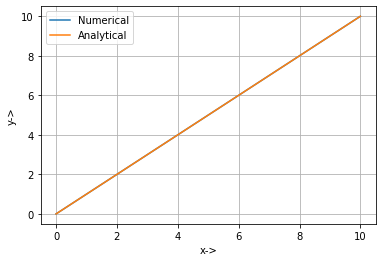

In [3]:
h = 0.1
Steps = int((10-0)/h) + 1 #Plus 1 because we want solution at y=10 too.
X = np.linspace(0, 10, Steps)
Y = [0]
for i in range(Steps-1): #because at i-th step loop evaluates i+1-th y.
    Y.append(h*1 + Y[-1])
    
py.plot(X, Y, label="Numerical")
py.plot(X, X, label = "Analytical")
py.grid()
py.xlabel('x->')
py.ylabel("y->")
py.legend()
py.show()

Both the graphs are identical! This seems to imply (as our intuition suggests) that no matter what $h$ we take for *this* problem, we would always get the analytical solution. Before we proceed to check this, let us write the above code in a neat function.

In [4]:
def EulerSingle(func, yi, xi, xf, steps):
    '''DOCSTRING for EulerSingle()
    The function solve a first order ODE y' = f(x, y).
    Input: (f, yi, xi, xf, steps)
    f: The function f(x, y)
    yi: Initial Condition
    xi: Initial x
    xf: Final x
    steps: Steps taken form xi to xf.
    
    The function returns two 1-D arrays, containing the x-points and the numerically obtained y-values at those points.
    The method is Explicit Euler Method.
    '''
    delta_x = (xf-xi)/(steps-1)
    XArray = np.linspace(xi, xf, steps)
    YArray = np.zeros(steps)
    YArray[0] = yi
    for i in range(1, steps):
        YArray[i] = YArray[i-1] + delta_x*func(XArray[i-1], YArray[i-1])
    return XArray, YArray



Instead of plotting the graph, we now compare the maximum absolute error obtained by using different $h$-values.

In [5]:
h_list =[10, 1, 0.5] #the h-values at which we want to check error.

def func(x, y):
    return 1

for h in h_list:
    xn, yn = EulerSingle(func, 0, 0, 10, steps = int((10-0)/h) + 1)
    error = max(abs(yn-xn))
    print("Error for h = " + str(h) + " is " + str(error))

Error for h = 10 is 0.0
Error for h = 1 is 0.0
Error for h = 0.5 is 0.0


Clearly, the error does not depend on what $h$ value we take as we expected. In fact, the error *increases* when we decrease the step size, due to floating point error accumulation. But leaving aside this technicality for now, we move on to solve an infinitely more complicated problem (yet, again, trivial analytically):

$$
y' = x + 1,\,  y_0 = 0
$$

The analytical solution is $y=x^2/2 + x$. Let use the same snippet as above and try to solve this.

In [6]:
h_list =[10, 1, 0.5, 0.1] #the h-values at which we want to check error.

def func_C(x, y):
    return x+1

for h in h_list:
    xn, yn = EulerSingle(func_C, 0, 0, 10, steps = int((10-0)/h) + 1)
    error = max(abs(yn-xn*xn/2 - xn))
    print("Error for h = " + str(h) + " is " + str(error))

Error for h = 10 is 50.0
Error for h = 1 is 5.0
Error for h = 0.5 is 2.5
Error for h = 0.1 is 0.5


Whoa, the error now is *huge*. This very simple modification has indeed increased the complexity of the equation, by introducing a new (although very expected) feature, dependence of the solution (and error) on $h$. Let us make our code modular, and introduce a function for the above snippet as well.

In [7]:
def plotter(X, Y_C, Y_A, title = "Title"):
    py.plot(X, Y_C, label="Numerical")
    py.plot(X, Y_A, label = "Analytical")
    py.grid()
    py.xlabel('x->')
    py.title(title)
    py.ylabel("y->")
    py.legend()
    py.show()

def ErrorCalc(func, yi, xi, xf, method, hlist, true, plot = False):
    '''DOCSTRING for ErrorCalc()
    The function solve a first order ODE y' = f(x, y).
    Input: (f, yi, xi, xf, steps)
    f: The function f(x, y)
    yi: Initial Condition
    xi: Initial x
    xf: Final x
    method: Which numerical method to employ
    hlist: Evaluate error at which value of h
    
    The function plots a graph between error and h-value.
    '''
    er = []
    for h in hlist:
        xn, yn = method(func, yi, xi, xf, steps = int((xf-xi)/h) + 1)
        error = max(abs(yn-true(xn)))
        if plot:
            title = "h is " + str(h)
            py.plot(xn, yn, label = "h= " + str(h))
        
            #plotter(xn, yn, true(xn), title)
        er.append(error)
    if plot:
        py.plot(xn, true(xn), label = "Analytical")
        py.grid()
        py.xlabel("x->")
        py.ylabel("y->")
        py.legend()
        py.show()
                  
    py.plot(hlist, er)
    py.xlabel('h->')
    py.grid()
    py.ylabel('Error->')
    py.show()
    return None
    


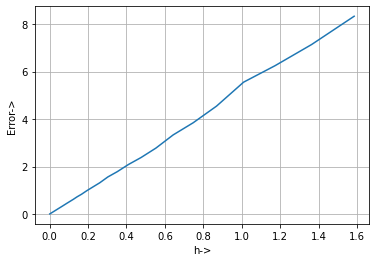

In [8]:
h_list = 10**np.linspace(-3, 0.2, 50)
def an_C(x):
    return x*x/2 + x 
ErrorCalc(func_C, 0, 0, 10, EulerSingle, h_list, an_C)

We conclude that at low values of $h$ the error depends linearly on $h$ (roughly, $5h$). We can also check how the $h$ values change the numerical solution qualitatively.

[1.e+01 2.e+00 1.e+00 1.e-01 1.e-03]


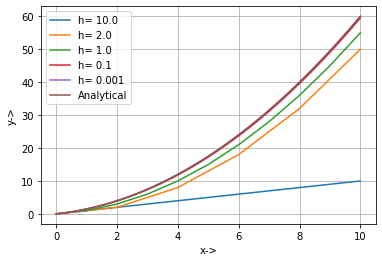

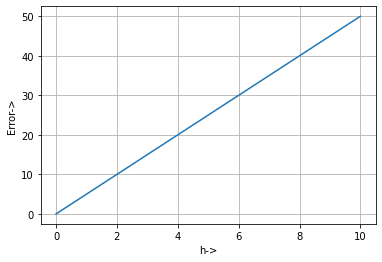

In [9]:
h_list2 = np.array([10, 2, 1, 0.1, 0.001])
print(h_list2)
ErrorCalc(func_C, 0, 0, 10, EulerSingle, h_list2, an_C, True)

Note that changing $h$ does not seem to change the qualitative nature of the solution, atleast when $h\leq1$.

Let us now make things more complicated. We eventually want to solve systems of differential equations of the following type:

$$
y' = ky
$$

Let us use our simple numerical method for this equation, for different values of $k$.

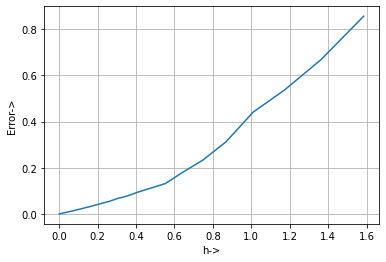

In [10]:
def an_F(x):
    return np.exp(-x)
def func_F(x, y):
    return -y
ErrorCalc(func_F, 1, 0, 10, EulerSingle, h_list, an_F)

In this case, it seems that the error grows quicker than $h$.

Let us now again see if changing $h$ makes any qualitative difference in the numerical solution.

[2.e+00 1.e+00 5.e-01 1.e-01 1.e-03]


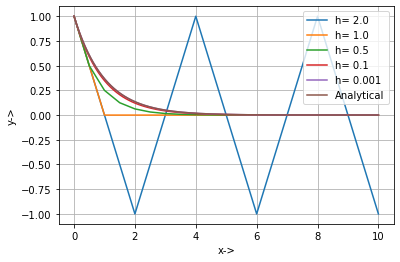

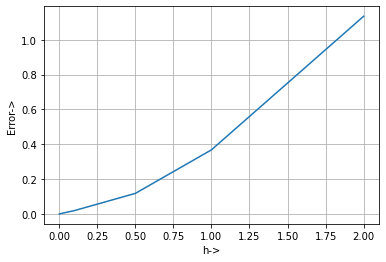

In [11]:
h_list2 = np.array([2, 1, 0.5, 0.1, 0.001])
print(h_list2)
ErrorCalc(func_F, 1, 0, 10, EulerSingle, h_list2, an_F, True)

This result is very surprising! It seems that the solution is qualitatively *very* different from an exponential decay when $h$ is a little too large. 
This makes the decay equation *stiff* to solve numerically. Before looking into numerical methods for stiff equations, let us just try one thing, let us see how does maximum $h$ (which does not change the behavior) vary with $k$. For this, we use lambda functions.

In [12]:
K_List = 10**np.linspace(0, 2, 80)
h_ini = 1
h_ans = [h_ini]
xi = 0
xf = 10
yi = 1
for K in K_List:
    #print(K)
    #input('c')
    function = lambda xp, yp: -K*yp
    h = h_ans[-1]
    flag = False
    while not flag:
        try:
            X, Y = EulerSingle(function, yi, xi, xf, steps = int((xf-xi)/h) + 1)
        except ZeroDivisionError:
            flag = True
            h_ans.append(xf-xi)
            break
        if min(Y)>0:
            flag = True
            h_ans.append(h)
            break
        h = h/2
            
    


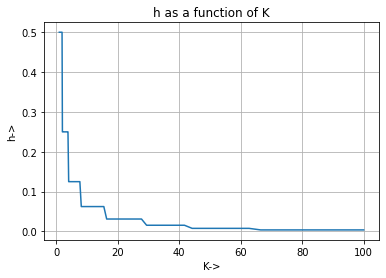

In [13]:
py.plot(K_List, h_ans[1:])
py.grid()
py.xlabel("K->")
py.ylabel("h->")
#py.ylim((0, 0.1))
py.title("h as a function of K")
py.show()

As $k$ decreases, the maximum tolerated value of $h$ increases and vice-versa. 
The result that as $|k|$ increases, so that $y' \sim 0$ the value of $h$ required decreases seems a litte counter-intuitive off-hand. One possible explanation can be that the exponential value becomes too small to be handled computationally. But that's not it, because even if we take into account the round-off and/or floating error (say, we do the numerical calculation by "hand") we still get such results. 

The equation in Euler's backward scheme is as follows,

$$
y_{n+1} = (1-kh)y_n
$$

Let $1-kh$ = $\alpha$. Suppose, that $\alpha>0$ but $<1$. In this regime, we simply get exponential decay as expected. Suppose, $\alpha$ = 0, the solution then is a just 0 (which is obviously wrong). In the $\alpha<0$ but $|\alpha|<1$ regime, we get damped oscillations. However, in the final regime, where $\alpha<-1$, the solutions are wildly oscillating. 
Note that, once we have fixed $k$, $\alpha$ is determined by $h$. So changing the value of $h$ changes the *behavior* of the numerical solution drastically. Only the first regime corresponds to (qualitatively) correct behavior.

The equations for which the above conclusions are true are called *stiff* equations, and the goal of this project is to compare different (standard) numerical methods for stiff equations, as well as point out couple of modifications to deal with the stiffness.

## Cure for Stiff Equations

### Defining Stiffness

Before moving on to methods to curtail the stiffness, it will be appropriate to *define* stiffness. However, this is not an easy task, since stiffness is more of a "philosophical" idea rather than a methamatical one.

We quote J. D. Lambert (from Numerical Methods for Ordinary Differential Systems):
>If a numerical method with a finite region of absolute stability, applied to a system with any initial conditions, is forced to use in a certain interval of integration a step length which is excessively small in relation to the smoothness of the exact solution in that interval, then the system is said to be stiff in that interval.

Note that, the it is not the *solution* that is stiff, but the differential system.

Essentially, what the above definition means is, that despite our function being sufficiently smooth we require an extremely small $h$ than otherise would be expected from the smoothness of the solution.

An appropriate measure for stiffness is called the *stiffness ratio*. Conisder the following set of differential equations for $y_1,\,y_2....y_N \equiv \mathbf{y}$,

$$
\mathbf{y}' = \mathbf{A}\mathbf{y} + \mathbf{f}(x).
$$

The $\mathbf{f}$ term is the inhomogenous term. Let us suppose that the solution of the above equation is of the form:


$$
\mathbf{y}(x) = \sum^{n}_{k=1} \exp (\lambda_k x)\mathbf{c}_k + \mathbf{g}(x).
$$

The $\mathbf{g}$ is the *steady-state* solution, and the first part is the *transient*. This requires that as $x\to\infty$ for each $\lambda_k$, $\exp (\lambda_k x)$ goes to 0. This decay is, obviously, dependent on the value $\lambda_k$. This causes transients to be either fast, slow or somewhere in the middle. The equation is said to be stiff, if the fastest and slowest decay are orders of magnitude different,

$$
\frac{\max |\lambda_k|}{\min |\lambda_k|} = \gamma,
$$

where $\gamma$ is the stiffness ratio, which allows us to characterize the stiffness of the differential equations.

Again, note that this "definition" is not exact. There exist a lot of issues with this definition, especially when one of the eigenvalues is 0. This is somewhat expected, because then it is not a transient, but a component of the steady-state solution. More details and disucissions on defining stiffness can be found in JD Lambert's book, *Numerical Methods for Ordinary Differential Systems*. Let us now leave the issue of definiing stiffness, and discuss numerical methods to solve the stiff differential equations. 

### Implicit Methods

Our Euler method is based on the forward derivative scheme. But we could also equally well use the backward derivative scheme,

$$
y_{n} = -hky_{n} + y_{n-1} \implies y_n  = \frac{y_{n-1}}{1+hk}
$$

Note that in this case no matter what is the value of $hk$, the solution is $always$ decaying. We can check this by writing a code for the implicit Euler method. 

In [14]:
def ImplicitForDecay(yi, xi, xf, delta_x, k):
    '''DOCSTRING for ImplicitForDecay()
    The function solve a the exponential decay first order ODE y' = -ky.
    Input: (f, yi, xi, xf, steps)
    yi: Initial Condition
    xi: Initial x
    xf: Final x
    deltaX: The step-size
    
    The function returns two 1-D arrays, containing the x-points and the numerically obtained y-values at those points.
    The method is Implicit Euler Method.
    '''
    steps = int((xf-xi)/delta_x) + 1
    XArray = np.linspace(xi, xf, steps)
    YArray = np.zeros(steps)
    YArray[0] = yi
    for i in range(1, steps):
        YArray[i] = YArray[i-1]/(1 + delta_x*k)#func(XArray[i-1], YArray[i-1]))
    return XArray, YArray
    
    

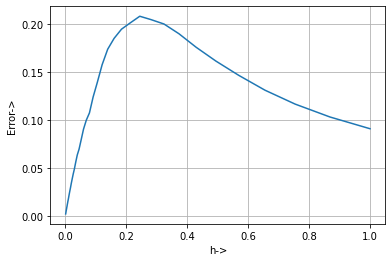

In [15]:
h_list =[20, 1, 0.5]
hList = 10**np.linspace(-3, 0, 50)
errList = []
k = 10

for h in hList:
    xn, yn = ImplicitForDecay(1, 0, 10, h, k)
    error = max(abs(yn-np.exp(-k*xn)))
    errList.append(error)

py.plot(hList, errList)
py.xlabel('h->')
py.grid()
py.ylabel('Error->')
py.show()

Note that the error is now not a simple monotonic function, but instead, it is something like $he^{-h}$. The peak's location is of the order of $1/k$.

We can also generalize the above method for a system of coupled differential equations. Consider the following system,

$$
\mathbf{y}' = -\mathbf{C}\cdot\mathbf{y}.
$$

First, under explicit differencing,

$$
\mathbf{y}_n = (\mathbb{I}-h\mathbf{C})^n \cdot \mathbf{y}_0.
$$

We can write the general solution in eigenbasis $\{\mathbf{e}_k\}$ as follows,

$$
\mathbf{y}_n = \sum \alpha_k (\mathbb{I}-h\lambda_k)^n \cdot \mathbf{e}_k.
$$

For stability, we have $|1-h\lambda_k|<1,\,\forall k$. This immediately gives the constraint that $h\lambda_{max} <2$.

Let us now look at implicit differencing,


$$
\mathbf{y}_n = (\mathbb{I}+h\mathbf{C})^{-n} \cdot \mathbf{y}_0.
$$

We can write the appropriate condition now as $|1+h\lambda_k|>1,\,\forall k$, which is trivially true for all $h$. The cost is that we now have to invert a matrix at each step. In general (which we will not try to go too deep into in this report) for $\mathbf{y}' = \mathbf{f(\mathbf{y})}$ we have to invert $\mathbb{I}-h\mathbb{J}$ at each time step, where $\mathbb{J}$ is the Jacobian of $\mathbf{f}$ with respect to $\mathbf{y}$.




## Solving Robertson's example

The principal aim of this report is to compare different numerical methods for solving Robertson's example. 
The problem is as follows: Three chemicals $A,\,B$ and $C$ are reacting as per the following equation,

$$
\begin{aligned}
\dot{x_1} &=& -0.04x_1 +10^4 x_2x_3\\
\dot{x_2} &=& 0.04x_1 - 3.10^7 x_2^2 -10^4 x_2x_3\\
\dot{x_3} &=& 3.10^7 x_2 ^2
\end{aligned}
$$

This is an initial value problem, with $x_1(0) = 1$ and $x_2(0)=x_3(0)=0$.
The chemical model is as follows,

$$
A \to B \\
2B \to B + C\\
B+C\to A+C
$$

The reaction rates come from experiments, and clearly, differ vastly in the magnitude. For a general reaction, 

$$
\sum_i r_{ji} G_i \to\sum_i q_{ji} G_i.
$$

The coeffcient matrices $r_{ji}$ and $q_{ji}$ are the *stoichometric coefficients* of reaction $j$, which has reaction rate $k_j$. The left side is the depletion and the right side is the generation. The differential equation for this system is,

$$
\dot{\mathbf{x}} = \mathbf{A} \cdot \mathbf{p}
$$

Note that $\mathbf{A}$ need not be a square matrix. In fact, $\mathbf{A} = \mathbf{Q} - \mathbf{R}$. The components of $\mathbf{A}$ are called as stoichometric coefficients, and are either positive or negative depending on whether there is net generation or depletion of the reactant. The vector $\mathbf{p}$ has components $p_j = k_j \Pi_{i} x_i^{r_{ji}}$. In Robertson's problem, $m = n = 3$ and, 

$$
\mathbf{A} = \begin{pmatrix}
-1&0&1\\
1&-1&-1\\
0&1&0
\end{pmatrix}.
$$

The vector $\mathbf{p}$ is,

$$
\mathbf{p} = \begin{pmatrix}
0.04x_1\\
3.10^7 x_2\\
10^4 x_2x_3
\end{pmatrix}.
$$

The net sum $x_1 + x_2 + x_3 = 1$ at all times.

## Using different numerical methods

We first define the "big" right side wrapped function as earlier.

In [34]:
def rightF(t, X):
    x0 = -0.04*X[0] + (1e4)*X[1]*X[2]
    x1 = 0.04*X[0] -3*(1e7)*(X[1]**2) -(1e4)*X[1]*X[2]
    x2 = 3*(1e7)*(X[1]**2)
    return np.array([x0, x1, x2])

def Jacobi(t, X):
    siz = len(X)
    JJ = np.zeros((siz, siz))
    JJ[0, 0] = - 0.04
    JJ[1, 0] = 0.04
    JJ[0, 1] = 1e4 * X[2]
    JJ[0, 2] = 1e4 * X[1]
    JJ[1, 2] = -1e4 * X[1]
    JJ[1, 1] = -6e7 * X[1] -1e4*X[2]
    JJ[2, 1] = 6e7*X[1]
    
    return JJ
#print(Jacobi(0, [0, -1, 0]))
ti = 0
tf = 40
X_i = np.array([0., 0.1, 0.9])

In [35]:
print("Rk4")
solRK45 = solve_ivp(rightF, (ti, tf), X_i, method = "RK45", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
print("Rk2")
solRK23 = solve_ivp(rightF, (ti, tf), X_i, method = "RK23", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
print("DOP")
solDOP = solve_ivp(rightF, (ti, tf), X_i, method = "DOP853", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
print("RAD")
solRad = solve_ivp(rightF, (ti, tf), X_i, method = "Radau", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
print("BDF")
solBDF = solve_ivp(rightF, (ti, tf), X_i, method = "BDF", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
print("LSO")
solLSO = solve_ivp(rightF, (ti, tf), X_i, method = "LSODA", jac = Jacobi)#, rtol=1e-5, atol=1e-7)
#solLSO = {"nfev":0}
#print(solRK45)#solDOP853
#solRadau
#solBDF
#solLSODA

Rk4


c:\users\hridey\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


Rk2


KeyboardInterrupt: 

In [18]:
SOL = [solRK45, solRK23, solDOP, solRad, solBDF, solLSO]
names = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]

for k in range(6):
    print(names[k] + " : " + str(SOL[k]["nfev"]))


RK45 : 292832
RK23 : 157985
DOP853 : 247454
Radau : 335
BDF : 273
LSODA : 189


We can also now define certain routines to see how well they fare.

In [19]:
def Euler(Func, yis, xi, xf, steps):
    try:
        dim = len(yis)
    except:
        dim = 1
    delta_x = (xf-xi)/(steps+1)
    XArray = np.linspace(xi, xf, steps)
    YArray = np.zeros((steps, dim))
    YArray[0] = yis
    vals = np.array(yis)+0.
    for i in range(1, steps):
        YArray[i] = YArray[i-1] + delta_x*Func(XArray[i-1], YArray[i-1])
    return {"t": XArray, "y": YArray.T, "nfev": steps-1}


In [20]:
c_array = np.array([0, .5, .5, 1])
b_array = np.array([1/6, 1/3, 1/3, 1/6])
a_matrix = np.array([
    [0, 0, 0, 0],
    [.5, 0, 0, 0],
    [0, 0.5, 0, 0],
    [0, 0, 1, 0]])

def RK4(Func, yis, xi, xf, steps):
    try:
        dim = len(yis)
    except:
        dim = 1
    
    delta_x = (xf-xi)/(steps-1)
    #print(delta_x)
    XArray = np.linspace(xi, xf, steps)
    #print(XArray)
    YArray = np.zeros((steps, dim))
    YArray[0] = yis
    vals = np.array(yis)+0.
    k_array = np.zeros((len(c_array), dim))

    for i in range(1, steps):
            
        for l in range(4):
            k_array[l] = Func(XArray[i-1] +c_array[l], YArray[i-1] + delta_x*np.dot(a_matrix[l],k_array))
        YArray[i] = YArray[i-1] + delta_x*np.dot(b_array, k_array)
    
    return {"t": XArray, "y": YArray.T, "nfev": 4*steps-4}

    
def semiImplicitEuler(Funcs, yis, xi, xf, steps):
    
    try:
        dim = len(yis)
    except:
        dim = 1

    
    delta_x = (xf-xi)/(steps-1)
    XArray = np.linspace(xi, xf, steps)
    YArray = np.zeros((steps, dim))
    YArray[0] = yis
    vals = np.array(yis)+0.
    Jacobian = np.zeros((dim, dim))
    hy = delta_x
    for i in range(1, steps):
        yhere = YArray[i-1]
        for j in range(dim):
            yp = yhere.copy()
            yp[j]+=hy
            Jacobian[j] = (Funcs(XArray[i-1], yp)-Funcs(XArray[i-1], yhere))/hy
        
        YArray[i] = yhere + delta_x*np.dot(np.linalg.inv(np.identity(dim)-delta_x*Jacobian), Funcs(XArray[i-1], yhere)) 
    return {"t": XArray, "y": YArray.T, "nfev":  2*dim*(steps-1) + steps-1}

def AdamsBashforth(Funcs, yis, xi, xf, steps):
        
    try:
        dim = len(yis)
    except:
        dim = 1

    
    delta_x = (xf-xi)/(steps-1)
    XArray = np.linspace(xi, xf, steps)
    YArray = np.zeros((steps, dim))
    YArray[0] = yis
    YArray[1] = YArray[0] + delta_x*Funcs(xi, YArray[0])
    vals = np.array(yis)+0.
    Jacobian = np.zeros((dim, dim))
    hy = delta_x
    
    for i in range(2, steps):
        YArray[i] = YArray[i-1]+ 0.5*delta_x*(3*Funcs(XArray[i-1], YArray[i-1]) - Funcs(XArray[i-2], YArray[i-2]))
    return {"t": XArray, "y": YArray.T, "nfev":  2*steps-2}

    


In [21]:
h=1e-3
steps = int((xf-xi)/h) + 1
solEul = Euler(rightF, X_i, ti, tf, steps) 
solRK4 = RK4(rightF, X_i, ti, tf, steps) 
solSIE = semiImplicitEuler(rightF, X_i, ti, tf, steps) 
solABM = AdamsBashforth(rightF, X_i, ti, tf, steps) 

C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/3640884290.py:2: RuntimeWarning: overflow encountered in double_scalars
  x0 = -0.04*X[0] + (1e4)*X[1]*X[2]
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/3640884290.py:3: RuntimeWarning: overflow encountered in double_scalars
  x1 = 0.04*X[0] -3*(1e7)*(X[1]**2) -(1e4)*X[1]*X[2]
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/3640884290.py:3: RuntimeWarning: invalid value encountered in double_scalars
  x1 = 0.04*X[0] -3*(1e7)*(X[1]**2) -(1e4)*X[1]*X[2]
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/3640884290.py:4: RuntimeWarning: overflow encountered in double_scalars
  x2 = 3*(1e7)*(X[1]**2)
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/2863924268.py:53: RuntimeWarning: invalid value encountered in subtract
  Jacobian[j] = (Funcs(XArray[i-1], yp)-Funcs(XArray[i-1], yhere))/hy


In [22]:
SOL = [solRK45, solRK23, solDOP, solRad, solBDF, solLSO, solEul, solRK4, solSIE, solABM]
names = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA", "Euler", "RK4", "SemiEuler", "Adams"]

for k in range(10):
    print(names[k] + " : " + str(SOL[k]["nfev"]))


RK45 : 292832
RK23 : 157985
DOP853 : 247454
Radau : 335
BDF : 273
LSODA : 189
Euler : 10000
RK4 : 40000
SemiEuler : 70000
Adams : 20000


0
3
5


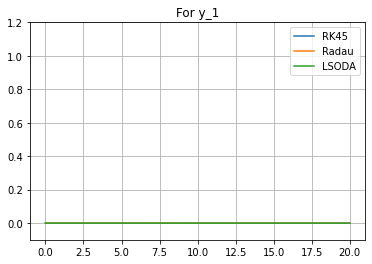

0
3
5


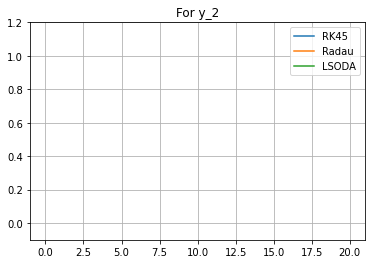

0
3
5


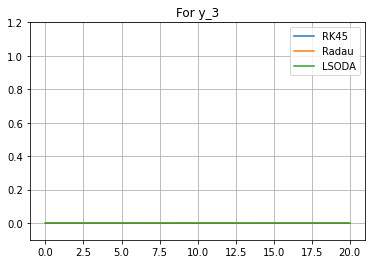

In [33]:
iL = [0, 1, 2, 3]
iL=[0, 3, 5]
for k in range(3):
    for i in iL:
        print(i)
        py.plot(SOL[i]["t"], SOL[i]["y"][k-1], label = names[i])
    py.legend()
    py.grid()
    py.ylim((-0.1, 1.2))
    py.title("For y_" + str(k+1))
    py.show()

## Van der Pol Oscillator

Consider one more problem, on which we can test our solvers. Without going into the physical details, consider the system below:

$$
\begin{aligned}
\dot{x} &=& y\\
\dot{y} &=&\mu (1-x^2)y - x
\end{aligned}
$$

In [24]:
def vanderF(t, X):
    return np.array([X[1], mu*(1-X[0]*X[0])*X[1] - X[0]])

def Jacobvander(t, X):
    Jaco = np.zeros((2, 2))
    Jaco[0, 1] = 1
    Jaco[1, 0] = X[1]*mu*(-2*X[0]) - 1
    Jaco[1, 1] = mu*(1-X[0]*X[0])
    return Jaco

In [25]:
mu = 1000
ti = 0
tf = 20
X_i = np.array([2, 0])
print("Rk4")
solRK45 = solve_ivp(vanderF, (ti, tf), X_i, method = "RK45", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
print("Rk2")
solRK23 = solve_ivp(vanderF, (ti, tf), X_i, method = "RK23", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
print("DOP")
solDOP = solve_ivp(vanderF, (ti, tf), X_i, method = "DOP853", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
print("RAD")
solRad = solve_ivp(vanderF, (ti, tf), X_i, method = "Radau", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
print("BDF")
solBDF = solve_ivp(vanderF, (ti, tf), X_i, method = "BDF", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
print("LSO")
solLSO = solve_ivp(vanderF, (ti, tf), X_i, method = "LSODA", jac = Jacobvander)#, rtol=1e-5, atol=1e-7)
#solLSO = {"nfev":0}
#print(solRK45)#solDOP853
#solRadau
#solBDF
#solLSODA


Rk4


c:\users\hridey\appdata\local\programs\python\python39\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  warn("The following arguments have no effect for a chosen solver: {}."


Rk2
DOP
RAD
BDF
LSO


In [26]:
SOL = [solRK45, solRK23, solDOP, solRad, solBDF, solLSO]
names = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA"]

for k in range(6):
    print(names[k] + " : " + str(SOL[k]["nfev"]))


RK45 : 126236
RK23 : 71027
DOP853 : 111698
Radau : 92
BDF : 99
LSODA : 56


0
1
2
3


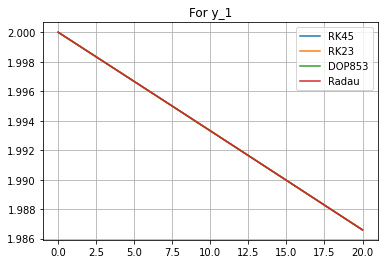

0
1
2
3


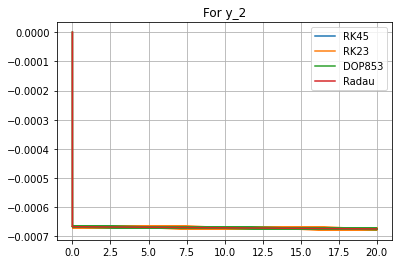

In [27]:
iL = [0, 1, 2, 3]
#iL=[0, 6, 5]
for k in range(2):
    for i in iL:
        print(i)
        py.plot(SOL[i]["t"], SOL[i]["y"][k], label = names[i])
    py.legend()
    py.grid()
    #py.ylim((-0.1, 1.2))
    py.title("For y_" + str(k+1))
    py.show()

In [28]:
h=1e-3
steps = int((xf-xi)/h) + 1
solEul = Euler(vanderF, X_i, ti, tf, steps) 
solRK4 = RK4(vanderF, X_i, ti, tf, steps) 
solSIE = semiImplicitEuler(vanderF, X_i, ti, tf, steps) 
solABM = AdamsBashforth(vanderF, X_i, ti, tf, steps) 

C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/1041248399.py:2: RuntimeWarning: overflow encountered in double_scalars
  return np.array([X[1], mu*(1-X[0]*X[0])*X[1] - X[0]])
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/200709432.py:12: RuntimeWarning: invalid value encountered in add
  YArray[i] = YArray[i-1] + delta_x*Func(XArray[i-1], YArray[i-1])
C:\Users\Hridey\AppData\Local\Temp/ipykernel_12916/2863924268.py:76: RuntimeWarning: invalid value encountered in add
  YArray[i] = YArray[i-1]+ 0.5*delta_x*(3*Funcs(XArray[i-1], YArray[i-1]) - Funcs(XArray[i-2], YArray[i-2]))


In [29]:
SOL = [solRK45, solRK23, solDOP, solRad, solBDF, solLSO, solEul, solRK4, solSIE, solABM]
names = ["RK45", "RK23", "DOP853", "Radau", "BDF", "LSODA", "Euler", "RK4", "SemiEuler", "Adams"]

for k in range(10):
    print(names[k] + " : " + str(SOL[k]["nfev"]))


RK45 : 126236
RK23 : 71027
DOP853 : 111698
Radau : 92
BDF : 99
LSODA : 56
Euler : 10000
RK4 : 40000
SemiEuler : 50000
Adams : 20000


0
5
8


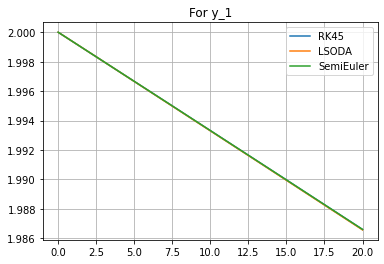

0
5
8


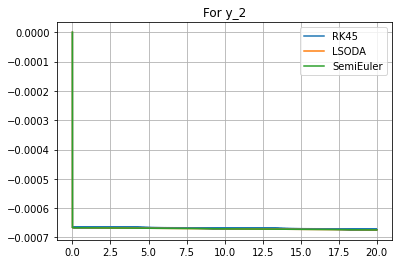

In [30]:
iL = [0, 1, 2, 3]
iL=[0, 5, 8]
for k in range(2):
    for i in iL:
        print(i)
        py.plot(SOL[i]["t"], SOL[i]["y"][k], label = names[i])
    py.legend()
    py.grid()
    #py.ylim((-0.1, 1.2))
    py.title("For y_" + str(k+1))
    py.show()

### References
1. *Robertson's example for stiff differential equations*, M.K. Gobbert
2. *Numerical Methods for ODEs*, J.D. Lambert
3. *Numerical Recipies in FORTRAN*, W.H. Press et. al.
4. *Van der Pol Oscillator*, Wikipedia
5. *Stiff Equations*, Wikipedia
6. *scipy.integrate.solve_ivp*, Scipy Manual